## STORE SALES TIMESERIES FORECAST - KAGGLE

### TABLE OF CONTENTS

A. **Pace: Plan stage**

    1. Introduction: Definition of forecasting task with identification of features and target

B. **pAce: Analyze stage**

    2. Data Preparation
    3. Data Visualization
    4. Multistep forecasting strategies: multioutput, direct, recursive, DiRec

C. **paCe: Construct stage**

    5. Model Construction: Boosted Hybrid vs Stacked hybrid

D. **pacE: Execute stage**

    6. Hyperparameter tuning
    7. Conclusion

### A. Plan Stage

1. Introduction: Definition of forecasting task with identification of features and target
    In this section, we will define the forecasting task and identify the relevant features and target variable.

#### Introduction

This project aims to forecast store sales using a time series dataset from Kaggle. The primary goal is to predict future sales for each product family sold at Favorita stores located in Ecuador. Accurate forecasts can help in inventory management, staffing, and overall business strategy.


#### Identification of Features and Target

Features:
- Store ID
- Date
- Promotion
- Holiday
- Day of the week
- Season
- Weather

Target:
- Sales 

In [1]:
%%time

## Imports

# Installing select libraries

## this install is particularly for dask
%pip install dask

%pip install catboost
%pip install colorama
%pip install category_encoders
%pip install optuna
%pip install xgboost
%pip install seaborn

# General library imports
import dask.dataframe as dd

from gc import collect
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import clear_output

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import sklearn as sk
import pandas as pd

print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}")
print(f"---> Sklearn = {sk.__version__} | Pandas = {pd.__version__}\n\n")
collect()

# Data manipulation and visualization
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Model and pipeline specifics
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Time series specific
from statsmodels.tsa.deterministic import DeterministicProcess

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from scipy.fft import fft

# Ensemble and tuning
import optuna
from optuna import create_study
optuna.logging.set_verbosity(optuna.logging.ERROR)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
---> XGBoost = 2.1.0 | LightGBM = 4.5.0 | Catboost = 1.2.5
---> Sklearn = 1.5.1 | Pandas = 2.2.2


CPU times: total: 3.41 s
Wall time: 1min 25s


In [2]:
# Setting rc parameters in seaborn for plots and graphs
sns.set({"axes.facecolor": "#f7f9fc",
          "figure.facecolor": "#f7f9fc",
          "axes.edgecolor": "#000000",
          "grid.color": "#EBEBE7",
          "font.family": "serif",
          "axes.labelcolor": "#000000",
          "xtick.color": "#000000",
          "ytick.color": "#000000",
          "grid.alpha": 0.4,
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        })

# Making sklearn pipeline outputs as dataframe
from sklearn import set_config
set_config(transform_output = "pandas")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

print()
collect()

4

In [3]:
favorita_train = dd.read_csv('data/train.csv')
favorita_test = dd.read_csv('data/test.csv')

stores = dd.read_csv('data/stores.csv')

transactions = dd.read_csv('data/transactions.csv')

oil = dd.read_csv('data/oil.csv')

holidays = dd.read_csv('data/holidays_events.csv')

In [4]:
favorita_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [5]:
favorita_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [6]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### B. pAce: Analyze stage

#### 2. Data Preparation

##### Merging the datasets together to create the train and test datasets

In [10]:
# Merge favorita_train and stores on 'store_nbr'
first_join = favorita_train.merge(stores, on='store_nbr', how='inner')

# Merge the result with transactions on 'store_nbr' and 'date'
second_join = first_join.merge(transactions, on=['store_nbr', 'date'], how='inner')

# Merge the result with oil on 'date'
third_join = second_join.merge(oil, on='date', how='inner')

# Merge the result with holidays on 'date'
final_join_train = third_join.merge(holidays, on='date', how='inner')

In [11]:
# Merge favorita_test and stores on 'store_nbr'
first_join = favorita_test.merge(stores, on='store_nbr', how='inner')

# Merge the result with oil on 'date'
second_join = first_join.merge(oil, on='date', how='inner')

# Merge the result with holidays on 'date'
third_join = second_join.merge(holidays, on='date', how='inner')

# Merge the result with transactions on 'store_nbr'

final_join_test = third_join.merge(transactions, on='store_nbr', how='inner')

In [12]:
# Display the head of the final DataFrame
final_join_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,561,2013-01-01,25,AUTOMOTIVE,0.00,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,562,2013-01-01,25,BABY CARE,0.00,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,563,2013-01-01,25,BEAUTY,2.00,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,564,2013-01-01,25,BEVERAGES,810.00,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,565,2013-01-01,25,BOOKS,0.00,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [13]:
final_join_test.head()

,id,date_x,store_nbr,family,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred,date_y,transactions
0,3015144,2017-08-24,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2013-01-02,2111
1,3015144,2017-08-24,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2013-01-03,1833
2,3015144,2017-08-24,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2013-01-04,1863
3,3015144,2017-08-24,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2013-01-05,1509
4,3015144,2017-08-24,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2013-01-06,520


In [14]:
final_join_train = final_join_train.compute()
final_join_test = final_join_test.compute()

In [15]:
final_join_train.shape

(322047, 17)

In [16]:
# Drop the date_y column
final_join_test.drop(columns=['date_y'])

# Rename the date_x column to date
final_join_test = final_join_test.rename(columns={'date_x': 'date'})

In [17]:
final_join_test.shape

(2755104, 17)

##### Cleaning up data

In [18]:
def clean_data(df):
    """
    This function cleans a given DataFrame by removing missing values, duplicate rows, and outliers.

    Parameters:
    df (DataFrame): The input DataFrame to be cleaned.

    Returns:
    df_clean (DataFrame): The cleaned DataFrame with missing values, duplicate rows, and outliers removed.
    """
    
    # Drop rows with missing values
    df.dropna(inplace=True)
    
    # Drop duplicate rows
    df.drop_duplicates(inplace=True)
    
    # Ensure there's data to work with
    if df.empty:
        return df
    
    # Remove outliers using the IQR method, but only for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if not numeric_cols:
        # If there are no numeric columns, return the cleaned DataFrame without attempting to remove outliers
        return df
    
    # Initialize an empty DataFrame to store the cleaned data
    df_clean = pd.DataFrame()
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers for this column
        temp_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
        # Append the filtered data to the cleaned DataFrame
        df_clean = pd.concat([df_clean, temp_df], ignore_index=True)
    
    return df_clean

In [19]:
# Apply the function to the train and test data
train_df = clean_data(final_join_train)
test_df = clean_data(final_join_test)

In [20]:
def select_one_id(df, id_column='id'):

    """
    This function selects and returns a DataFrame with unique rows based on a specified column.
    It drops duplicate rows based on the specified column, keeping the first occurrence.

    Parameters:
    df (DataFrame): The input DataFrame from which to select unique rows.
    id_column (str): The name of the column to use for identifying unique rows. Default is 'id'.

    Returns:
    df_unique (DataFrame): A new DataFrame containing only the unique rows based on the specified column.
    """
    
    # Drop duplicate rows based on the 'id' column, keeping the first occurrence
    df_unique = df.drop_duplicates(subset=[id_column], keep='first')
    return df_unique

In [21]:
# Assuming your DataFrame is named final_join_train_clean for the train data and final_join_test_clean for the test data
train_df = select_one_id(train_df)
test_df = select_one_id(test_df)

In [22]:
train_df.shape

(275682, 17)

In [23]:
test_df.shape

(1782, 17)

In [24]:
test_df = test_df.drop(columns=['date_y'])
test_df.shape

(1782, 16)

In [25]:
test_df.head()

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred,transactions
0,3015144,2017-08-24,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2111
1676,3015145,2017-08-24,1,BABY CARE,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2111
3352,3015146,2017-08-24,1,BEAUTY,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2111
5028,3015147,2017-08-24,1,BEVERAGES,26,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2111
6704,3015148,2017-08-24,1,BOOKS,0,Quito,Pichincha,D,13,47.24,Holiday,Local,Ambato,Fundacion de Ambato,False,2111


#### Feature Engineering

Features:
 -Product family
- City
- Percent oil
- Locale
- Date(dayoftheweek)
- Date(quartile)
- Date(month)
- Date(year)
- Type_y
- Promotion
- Store number
- Cluster
- Description
- Transferred holidays


Target:
- Sales

In [26]:
# Feature Engineering
# Create new features, encode categorical variables, etc.

# 1. Creating the time-step features

# Convert 'date' column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

## train dataset

train_df['day'] = train_df['date'].dt.day
train_df['dayOfWeek'] = train_df['date'].dt.dayofweek
train_df['month'] = train_df['date'].dt.month
train_df['quarter'] = train_df['date'].dt.quarter
train_df['year'] = train_df['date'].dt.year
train_df['dayofyear'] = train_df['date'].dt.dayofyear

## test dataset

test_df['day'] = test_df['date'].dt.day
test_df['dayOfWeek'] = test_df['date'].dt.dayofweek
test_df['month'] = test_df['date'].dt.month
test_df['quarter'] = test_df['date'].dt.quarter
test_df['year'] = test_df['date'].dt.year
test_df['dayofyear'] = test_df['date'].dt.dayofyear

# 2. Creating lag features

## train dataset;

for i in range(1, 6): # creating lag features for the past 5 time steps
    train_df[f'lag_{i}'] = train_df['sales'].shift(i)

## No lag features for our test dataset: you know why!

# 3. Creating rolling average features

## train dataset

train_df['rolling_mean_3'] = train_df['sales'].rolling(window=3).mean()
train_df['rolling_mean_7'] = train_df['sales'].rolling(window=7).mean()

# 4. window features

## train dataset

# Creating window features
train_df['window_sum_3'] = train_df['sales'].rolling(window=3).sum()
train_df['window_max_7'] = train_df['sales'].rolling(window=7).max()

# 5. Creating exponential smoothing features

## train dataset

alpha = 0.5  # Smoothing factor

train_df['exp_smoothing_3'] = train_df['sales'].ewm(alpha=alpha, adjust=False).mean()
train_df['exp_smoothing_7'] = train_df['sales'].ewm(alpha=alpha, adjust=False).mean()

## Next we create the 'percent_oil_per_city' column for both the train and test datasets;
total_revenue = train_df['dcoilwtico'].sum()
revenue_per_city = train_df.groupby('city')['dcoilwtico'].sum()
proportion_per_city = revenue_per_city / total_revenue
city_revenue = proportion_per_city.to_dict()

train_df['percent_oil_per_city'] = train_df['city'].map(city_revenue)
test_df['percent_oil_per_city'] = test_df['city'].map(city_revenue)

## Drop the 'dcoilwtico' column
train_df.drop(['dcoilwtico', 'id'], axis = 1, inplace=True)
test_df.drop(['dcoilwtico', 'id'], axis = 1, inplace=True)

#### 3. Data Visualization

##### Date-Time Features

##### Line plot

In [32]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

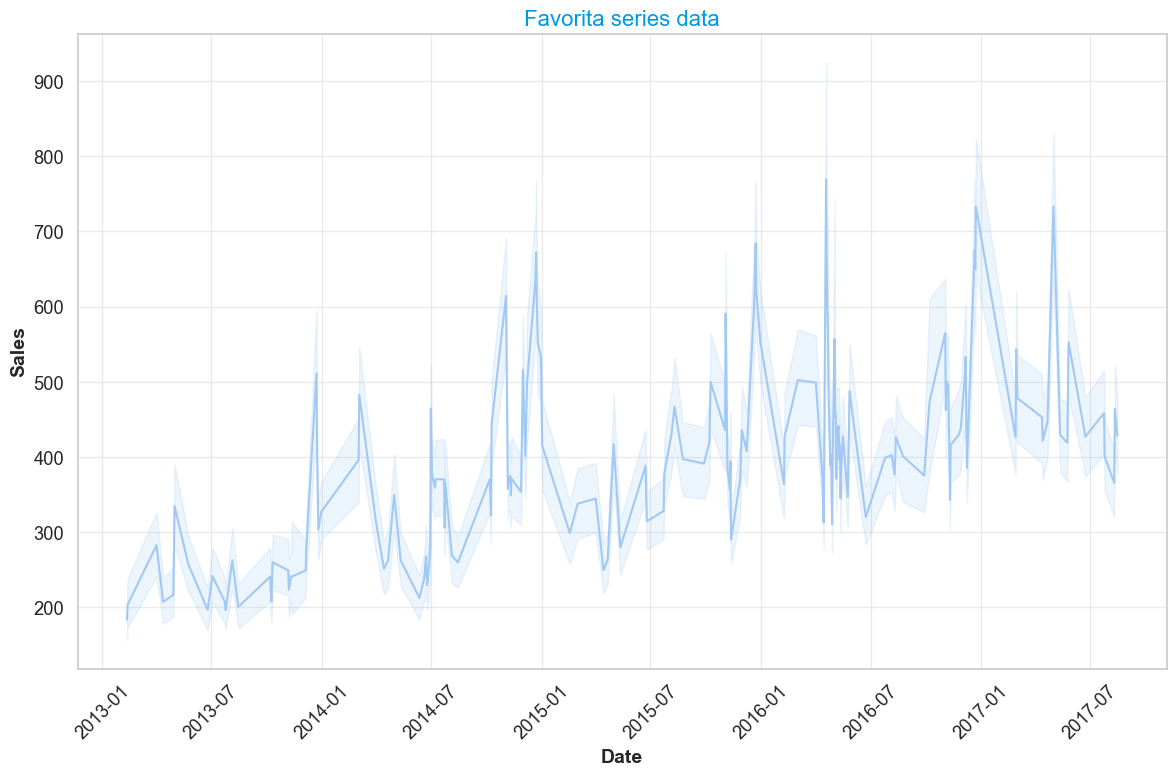

In [33]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='sales', data=train_df)
plt.title('Favorita series data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 365 Days Moving average

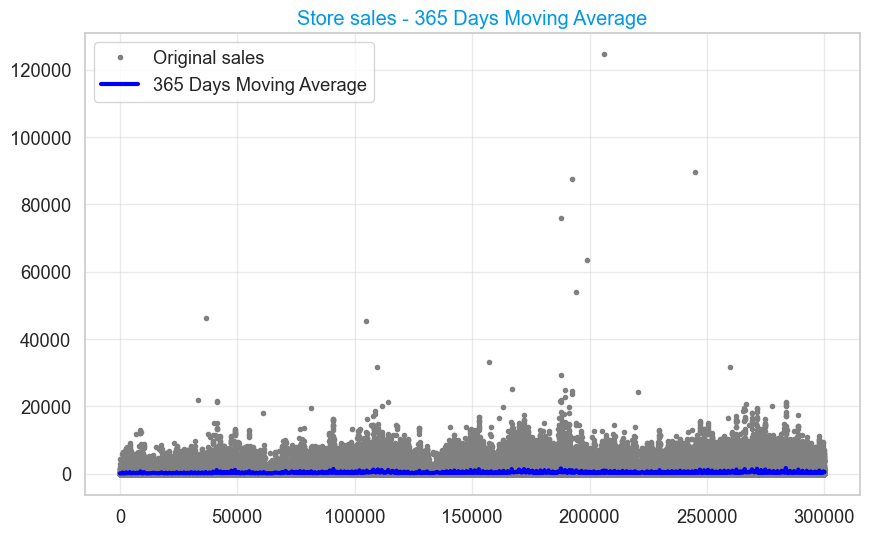

In [34]:
# Calculate the moving average
moving_avg = train_df['sales'].rolling(
    window=365, 
    center=True,
    win_type='hamming',
    min_periods=183,
    axis=0,
    closed=None,
).mean()

# Create a figure and axes object for more complex plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original data
ax.plot(train_df['sales'], '.', color='gray', label='Original sales')

# Plot the moving average
ax.plot(moving_avg, linewidth=3, color='blue', label="365 Days Moving Average")

# Set the title and legend
ax.set_title("Store sales - 365 Days Moving Average")
ax.legend()

# Show the plot
plt.show()

##### Bar plot of Sales by Month

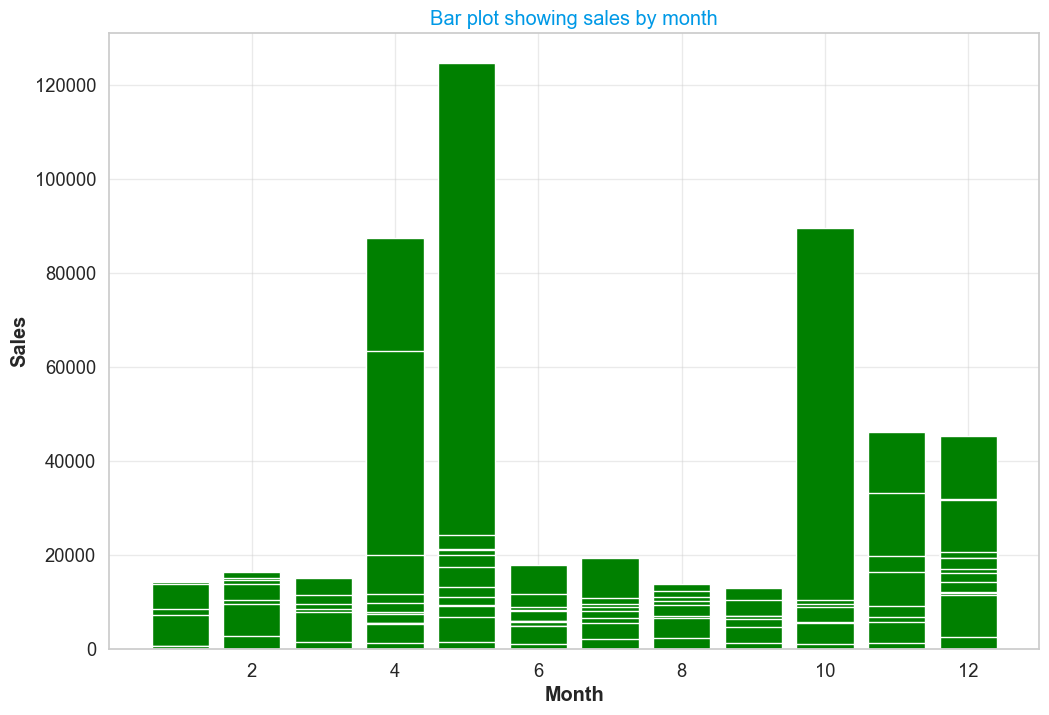

In [35]:
# Bar plot
plt.figure(figsize=(12, 8))
plt.bar(train_df['month'], train_df['sales'], color='green')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Bar plot showing sales by month')
plt.show()

##### Lag plot of Sales

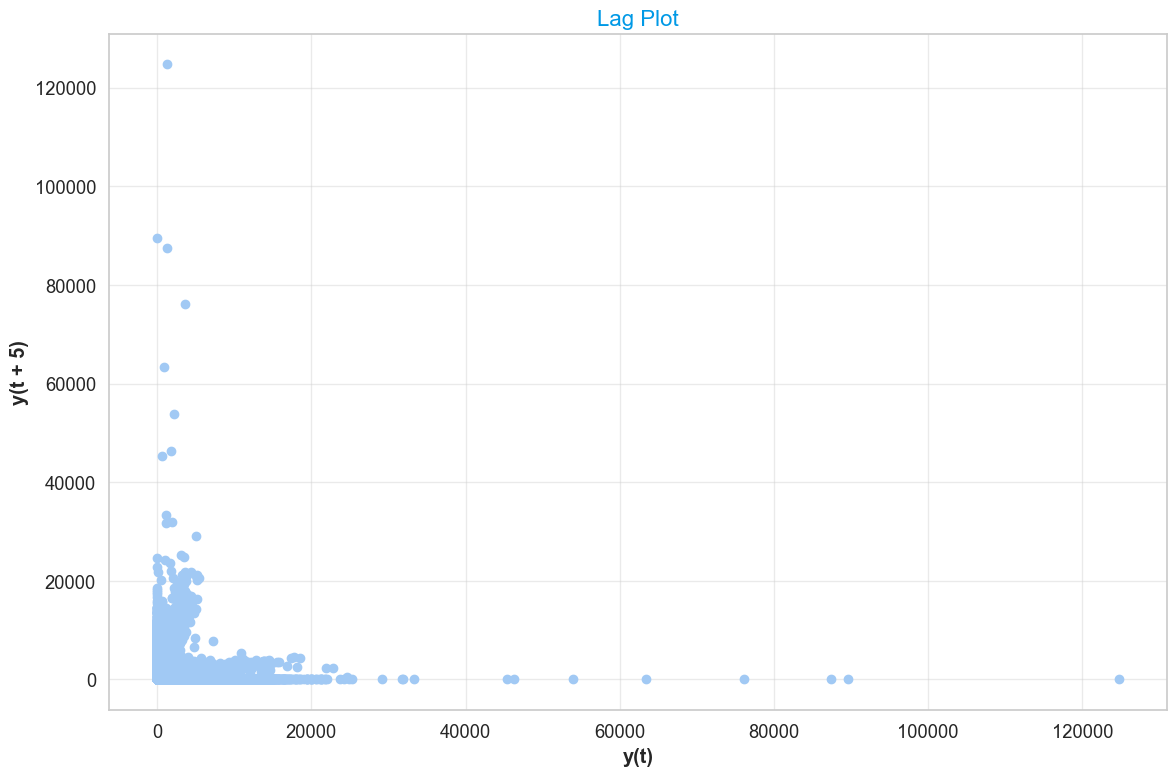

In [36]:
plt.figure(figsize=(12, 8))
pd.plotting.lag_plot(train_df['sales'], lag=5)
plt.title('Lag Plot', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Pairplot of Sales and Transactions

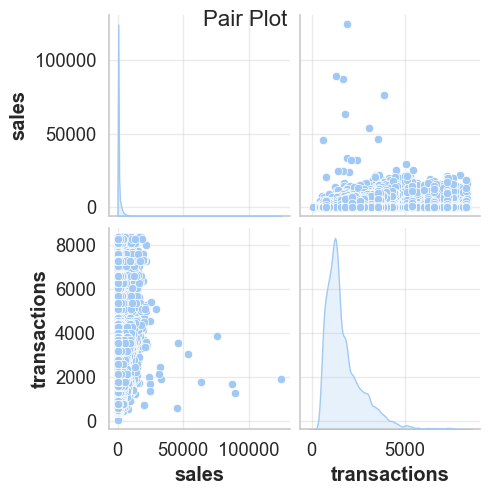

In [37]:
sns.pairplot(train_df[['sales', 'transactions']], diag_kind='kde')
plt.suptitle('Pair Plot', fontsize=16)
plt.show()

##### Sales Distribution by Store. 

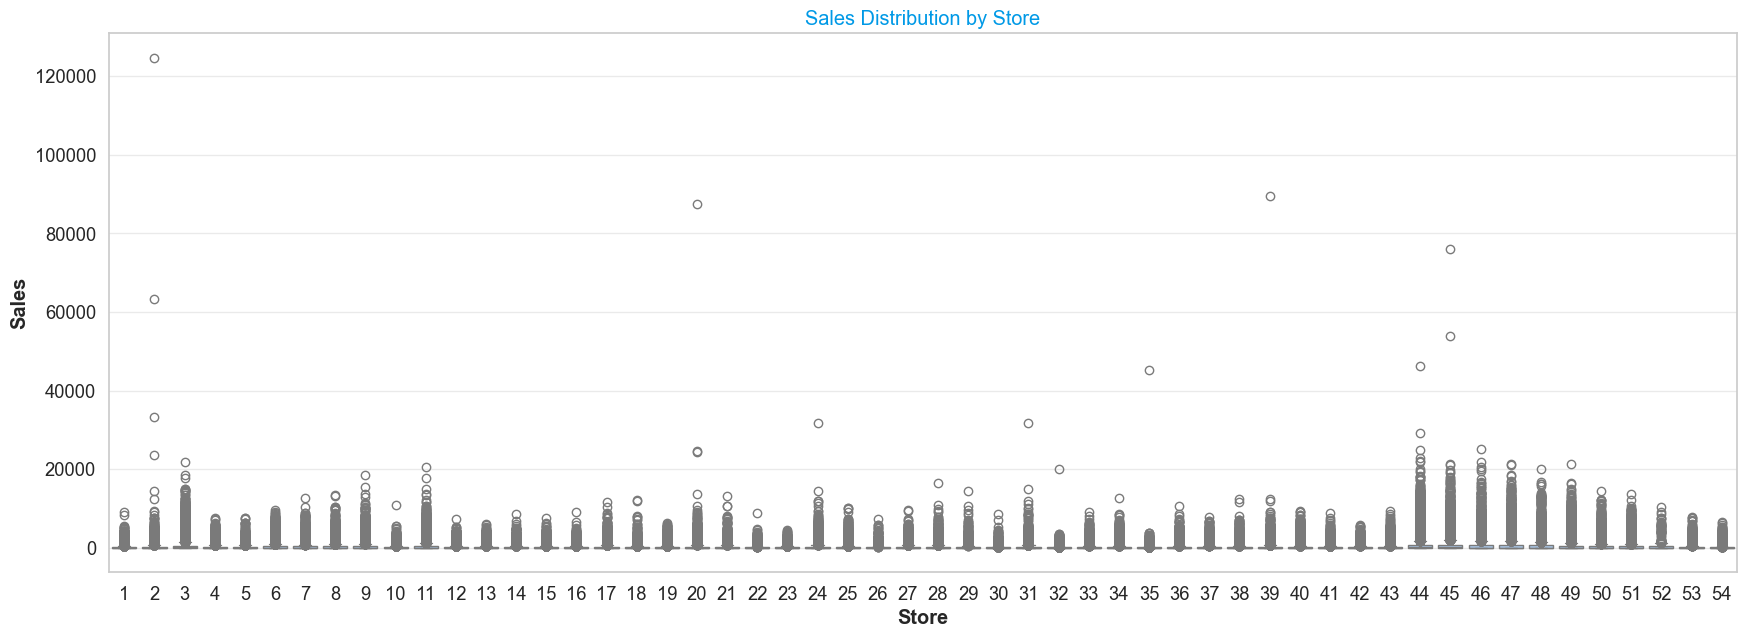

In [38]:
# Sales distribution by store
plt.figure(figsize=(21, 7))
sns.boxplot(x='store_nbr', y='sales', data=train_df)
plt.title('Sales Distribution by Store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.show()

### C. paCe: Construct stage

##### configuring features for the boostedHybrid model

In [58]:
## selecting target
y = train_df.loc[:, 'sales']

## X_1: features for linear regression
dp = DeterministicProcess(
    index = y.index,
    order = 1
)

X_1 = dp.in_sample()

## X_2: features for XGBoost
X_2 = train_df.drop('sales', axis=1).stack()

## label encoding for 'city', 'state', 'type_x', 'type_y', 'locale', 'locale_name', 'description'
categorical_columns = ['city', 'state', 'type_x', 'type_y', 'locale', 'locale_name', 'description']

le = LabelEncoder() 

for column in categorical_columns:
    # Fit and transform the column
    train_df[column] = le.fit_transform(train_df[column])

#### Creating the boosted hybrid model

In [47]:
class boostedHybrid():
    def __init__(self, model_1, model_2): 
        """
        Initialize a boosted hybrid model with two base regressors.

        Parameters:
        model_1 (estimator): The first base regressor for the boosted hybrid model.
        model_2 (estimator): The second base regressor for the boosted hybrid model.

        Attributes:
        model_1 (estimator): The first base regressor for the boosted hybrid model.
        model_2 (estimator): The second base regressor for the boosted hybrid model.
        y_columns (None or list of str): The column names of the target variable. Set to None initially.
        """
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None # store columns from the fit method
    
    def fit (self, X_1, X_2, y):
        """
        Fit the boosted hybrid model using two base regressors.

        Parameters:
        X_1 (DataFrame): Input data for the first base regressor.
        X_2 (DataFrame): Input data for the second base regressor.
        y (DataFrame): Target variable.

        Returns:
        None. The function fits the models `model_1` and `model_2` using the provided input data and target variable.
        """
        # fit self.model_1
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(self.model_1.predict(X_1), index=X_1.index, columns=self.y_columns)

        # compute residuals 
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()

        # fit self.model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # save column names for predict method
        self.y_columns = y.columns

        boostedHybrid.fit = fit

    def predict(self, X_1, X_2):
        """
        Predict the target variable using the boosted hybrid model.

        Parameters:
        X_1 (DataFrame): Input data for the first base regressor.
        X_2 (DataFrame): Input data for the second base regressor.

        Returns:
        y_pred (DataFrame): Predicted target variable. The index of the DataFrame is set to the index of X_1, and the columns are set to self.y_column. The DataFrame is then stacked and unstacked to match the original shape of the target variable.
        """
        y_pred = pd.DataFrame(self.model_1.predict(X_1), index = X_1.index, columns = self.y_column)
        y_pred = y_pred.stack().squeeze() # for too long index

        # add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)
        boostedHybrid.predict = predict
        
        return y_pred.unstack()

# # Model Construction
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression

In [59]:
X_1

,trend
0,1.00
1,2.00
2,3.00
3,4.00
4,5.00
...,...
299998,"275,678.00"
299999,"275,679.00"
300000,"275,680.00"
300001,"275,681.00"


In [57]:
# Define the base regressors
model_1_list = [LinearRegression(), ElasticNet(), Lasso(), Ridge()]
model_2_list = [xgb.XGBRegressor(), RandomForestRegressor(), KNeighborsRegressor(), cb.CatBoostRegressor()]

# Initialize variables to store the best model and its RMSLE
best_model = None
best_rmsle = float('inf')

# Iterate through all combinations of model_1 and model_2
for model_1 in model_1_list:
    for model_2 in model_2_list:
        # Create the boosted hybrid model
        model = boostedHybrid(model_1, model_2)

        # Fit the model
        model.fit(X_1, X_2, y)

        # Predict
        y_pred = model.predict(X_1, X_2)

        # Calculate RMSLE
        rmsle_score = np.sqrt(mean_squared_log_error(y, y_pred))

        # Update the best model and its RMSLE if a better model is found
        if rmsle_score < best_rmsle:
            best_model = model
            best_rmsle = rmsle_score

# Print the best model and its RMSLE
print("Best Model:", best_model)
print("Best RMSLE:", best_rmsle)

MemoryError: Unable to allocate 566. GiB for an array with shape (275681, 275682) and data type float64

In [ ]:
# D. Execute Stage

## 6. Hyperparameter tuning
# This section focuses on tuning the hyperparameters of the models to improve performance.

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Grid search for boosted model
grid_search = GridSearchCV(boosted_model, param_grid, cv=3, scoring='neg_mean_squared_log_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters for boosted model:", best_params)

# Update boosted model with best parameters
boosted_model = GradientBoostingRegressor(**best_params)
boosted_model.fit(X_train, y_train)

## 7. Conclusion
# Summarize findings and discuss the next steps.

# Conclusion
"""
In this project, we explored various techniques for forecasting store sales using time series data. We prepared and visualized the data, implemented different multi-step forecasting strategies, and compared the performance of boosted and stacked hybrid models. Further improvements can be made through advanced hyperparameter tuning and incorporating additional features.
"""

# Save the best model
import joblib

# Save the best model
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')
